In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.corpus import stopwords
import string

In [56]:
#Reading the 5 csv files, each one containts 160 reviews - 80 Real with label 0 and 80 false with label 1
fold1 = pd.read_csv("fold1.csv")
fold2 = pd.read_csv("fold2.csv")
fold3 = pd.read_csv("fold3.csv")
fold4 = pd.read_csv("fold4.csv")
fold5 = pd.read_csv("fold5.csv")

fold1.head(3)

#create a combined dataset for analysis
train_df = pd.concat([fold1,fold2,fold3,fold4], ignore_index=True)
whole_df = pd.concat([fold1,fold2,fold3,fold4,fold5], ignore_index=True)
whole_df.head(3)

,Review,Fake
0,We stayed at the Schicago Hilton for 4 days an...,1
1,My $200 Gucci sunglasses were stolen out of my...,0
2,Hotel is located 1/2 mile from the train stati...,1


First step is lowercasing, as it is a very common technique in nlp. It converts "word", "WORD", "Word", e.t.c into "word" thus making the dictionary of words smaller and also giving the word the weight that it suits it...
BUT in many cases some negative reviews have fully capitalized words that shows frustration and anger, for example "THIS IS HORRIBLE" and by lowercasing every word we might lose information.. 
So A custom function suits us that will lowercase the words that start with a Capital character and the rest of the characters are lowercased.

In [57]:
def custom_lowercase(text):
    """custom function to lowercase the words that only their first character is capital"""
    new_text = ""
    for word in str(text).split():
        if len(word)>1:
            if word[0].isupper() and word[1].islower():
                word = word[0].lower() + word[1:]
                new_text = new_text +" "+ word
            else:
                new_text = new_text +" "+ word
        elif word[0].isupper():
                word = word[0].lower() 
                new_text = new_text +" "+ word
        else:
            new_text = new_text +" "+ word
    return new_text

whole_df["Review"] = whole_df["Review"].apply(lambda text: custom_lowercase(text))
whole_df.iloc[50:60]

,Review,Fake
50,james chicago; the luxurious nice hotel as it...,1
51,"me, my sister and my best friend all went to ...",0
52,DO NOT STAY HERE!! my wife and i were visitin...,1
53,i stayed in a deluxe king suite. no desk to w...,0
54,"a recent stay at the james hotel-Chicago, rev...",1
55,this hotel does not belong in the same league...,0
56,the hotel was not one of the better ones i st...,1
57,i haven't actually stayed at this hotel- yet-...,0
58,i had a business trip coming up in chicago an...,1
59,this hotel was not worth it. from the moment ...,0


Continuing, contractions affect the quality of our Review and some words could be accounted multiple times instead of the correct number. For example "Y'all" should be two tokens when examining the review, correct form is "You all". 
So we will transform contractions into their original form.

In [58]:
import contractions
whole_df["Review"] = whole_df["Review"].apply(lambda x: contractions.fix(x))
whole_df.iloc[50:60]

,Review,Fake
50,james chicago; the luxurious nice hotel as it...,1
51,"me, my sister and my best friend all went to ...",0
52,DO NOT STAY HERE!! my wife and i were visitin...,1
53,i stayed in a deluxe king suite. no desk to w...,0
54,"a recent stay at the james hotel-Chicago, rev...",1
55,this hotel does not belong in the same league...,0
56,the hotel was not one of the better ones i st...,1
57,i have not actually stayed at this hotel- yet...,0
58,i had a business trip coming up in chicago an...,1
59,this hotel was not worth it. from the moment ...,0


Next step is to remove punctuations from text, we are going to use the already made list from string BUT we are not going to remove "!" because in many reviews the number of "!" next to words can carry some information. Similar idea to the capitalization..
In general we remove puncuation for the same reason as before, to treat "word" and "word." as the same, it will lower the number instances in the dictionary and will help assign the proper weights to the "word" which has the same meaning in both cases.

*IMPORTANT TO STATE: by examining our dataset no emoticons like ":)" were used in the reviews, so there is no loss of information by removing every puncuation. In case there were emoticons the proper way was to first "translate" them with their meaning and then removing all the reaming  punctuations

In [59]:
#the "0" index of the list is "!" so we skip it
punctuation_list = string.punctuation[1:]
print(punctuation_list)
def remove_punctuation(text):
    """custom function to remove all punctuation except !"""  
    return text.translate(str.maketrans('', '', punctuation_list))

whole_df["Review"] = whole_df["Review"].apply(lambda text: remove_punctuation(text))
whole_df.iloc[50:55]

"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,Review,Fake
50,james chicago the luxurious nice hotel as it ...,1
51,me my sister and my best friend all went to s...,0
52,DO NOT STAY HERE!! my wife and i were visitin...,1
53,i stayed in a deluxe king suite no desk to wo...,0
54,a recent stay at the james hotelChicago revea...,1


Next step is the removal of stop words from our Reviews. Stopwords usually do not carry any meaning and account for a large number of words, by removing them we have less instances in our dictionary and the training of our algorithms will take less time as less words will be examined each time. 
NLTK has a list of stopwords which is the common list used in most nlp tasks

In [60]:
STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove  stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

whole_df["Review"] = whole_df["Review"].apply(lambda text: remove_stopwords(text))
whole_df.iloc[50:55]

,Review,Fake
50,james chicago luxurious nice hotel advertised ...,1
51,sister best friend went stay summer 2004they s...,0
52,DO NOT STAY HERE!! wife visiting family chicag...,1
53,stayed deluxe king suite desk work sit eat roo...,0
54,recent stay james hotelChicago revealed recent...,1


Let's try stemming as well.

In [49]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

whole_df["Review"] = whole_df["Review"].apply(lambda text: stem_words(text))
whole_df.iloc[50:55]

,Review,Fake
50,jame chicago luxuri nice hotel advertis want s...,1
51,sister best friend went stay summer 2004they s...,0
52,DO not stay here!! wife visit famili chicago d...,1
53,stay delux king suit desk work sit eat room se...,0
54,recent stay jame hotelchicago reveal recent up...,1


In [61]:
#LEMMATIZATION
#nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

whole_df["Review"] = whole_df["Review"].apply(lambda text: lemmatize_words(text))

Next, to make our dictionary even smaller and the iteration of the algorithms even faster we want to remove frequent used words that are frequent in Both FAKE AND TRUE reviews, because with a balanced dataset such as ours we can't blindly remove frequent words as they could be frequent only at one of the two labels.
For that we create a custom function that searches for frequent words in the Reviews of each label seperately, then we compare the list of the 20 most frequent words from each case and remove the words appearing in both cases.

*The reaming words from each list will be features with high importance for the label they belong 

In [62]:
from collections import Counter
#seperate the dataframes
#Important to look only on the training set while extracting the frequent words
fake_df = train_df.loc[whole_df['Fake'] == 1]
real_df = train_df.loc[whole_df['Fake'] == 0]

def counts(df):
    cnt = Counter()
    for text in df["Review"].values:
        for word in text.split():
            cnt[word] += 1
    return cnt

fake_cnts = counts(fake_df)
real_cnts = counts(real_df)
        
def get_list(lis):
    words = []
    for pair in lis:
        words.append(pair[0])
    return words

fake_common = get_list(fake_cnts.most_common(20))
real_common = get_list(real_cnts.most_common(20))
freq_to_remove = list(set(fake_common).intersection(real_common))

def remove_freq(text, freq):
    """custom function to remove freq words"""
    return " ".join([word for word in str(text).split() if word not in freq])

whole_df["Review"] = whole_df["Review"].apply(lambda text: remove_freq(text,freq_to_remove))
whole_df.iloc[50:55]

,Review,Fake
50,james chicago luxurious nice advertise want st...,1
51,sister best friend go stay summer 2004they say...,0
52,DO NOT STAY HERE!! wife visit family chicago d...,1
53,stay deluxe king suite desk work sit eat servi...,0
54,recent stay james hotelChicago reveal recent u...,1


There are also other pre-processing options. One option is removing Rare words, but rare words could carry meaning and we could also dictate that through the algorithm initialization. 
Additionally, there were no noise in the data like HTML tags or URLS that should be removed..


Now we procced to the feature extraction phase, using the TfIdf vectorizer from sklearn so it normalizes the counts of the features that appear as common. Explanation follows from sklearn:
With the TFIDFVectorizer the value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus; that is the inverse document frequency (IDF) part.

First though we are going to seperate the dataset again into train and test

The inverse document frequency adjusts for the fact that some words appear more frequently in general. For example, even though words like “we”, and “the” appear often in documents, since it appears often in all documents, they don’t tell me a lot about what makes this document unique. It’s more interesting to know if words like “crepuscular” or “petrichor” appear a lot in a document because it doesn’t appear frequently in the corpus. “petrichor” tells us a lot more about what the document is about than “we” and “the”.

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
#from nltk.tokenize import word_tokenize 

#whole_df["Tokens"] = whole_df["Review"].apply(lambda text: word_tokenize(text))

X = whole_df['Review']
Y = whole_df['Fake']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)

uni_vector = TfidfVectorizer(lowercase=False, ngram_range=(1, 1))
features_uni = uni_vector.fit_transform(X_train).toarray()

bi_vector = TfidfVectorizer(lowercase=False, ngram_range=(1, 2))
features_bi = bi_vector.fit_transform(X_train).toarray()

X_train_trans_uni = uni_vector.fit_transform(X_train)
X_test_trans_uni = uni_vector.transform(X_test)

X_train_trans_bi = bi_vector.fit_transform(X_train)
X_test_trans_bi = bi_vector.transform(X_test)


lets find the 5 most important features for each class

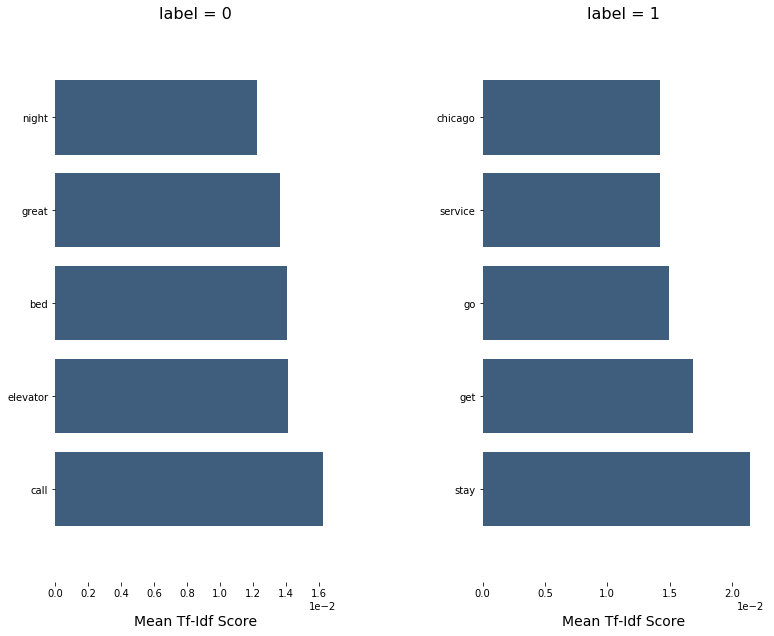

In [64]:
%matplotlib inline
from matplotlib import pyplot as plt

#features_uni for features per instance
names = uni_vector.get_feature_names()

def top_tfidf_feats(row, features, top_n=5):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=5):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]#.toarray()
    else:
        D = Xtr#.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=5):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()
    
plot_tfidf_classfeats_h(top_feats_by_class(features_uni,y_train, names ))

Multinomial Naive Bayes for both unigram and bigram..

In [65]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes_uni = MultinomialNB().fit(X_train_trans_uni, y_train)
naive_bayes_bi = MultinomialNB().fit(X_train_trans_bi, y_train)

#uni
predictions_uni = naive_bayes_uni.predict(X_test_trans_uni)

#bi
predictions_bi = naive_bayes_bi.predict(X_test_trans_bi)

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
print("for unigram model")
print("Accuracy score: ", accuracy_score(y_test, predictions_uni))
print("Precision score: ", precision_score(y_test, predictions_uni))
print("Recall score:" , recall_score(y_test, predictions_uni))
print("f1 score:" , f1_score(y_test, predictions_uni))
print("Confusion Matrix:", confusion_matrix(y_test, predictions_uni))

print("for bigram model")
print("Accuracy score: ", accuracy_score(y_test, predictions_bi))
print("Precision score: ", precision_score(y_test, predictions_bi))
print("Recall score:" , recall_score(y_test, predictions_bi))
print("f1 score:" , f1_score(y_test, predictions_bi))
print("Confusion Matrix:", confusion_matrix(y_test, predictions_bi))

for unigram model
Accuracy score:  0.79375
Precision score:  0.7238095238095238
Recall score: 0.95
f1 score: 0.8216216216216217
Confusion Matrix: [[51 29]
 [ 4 76]]
for bigram model
Accuracy score:  0.83125
Precision score:  0.7623762376237624
Recall score: 0.9625
f1 score: 0.8508287292817679
Confusion Matrix: [[56 24]
 [ 3 77]]


Let's use chi2 to select the 1000 most important features to see if we can improve with a less sparse Doc

In [67]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#initial features
print(features_uni.shape)
print(features_bi.shape)

#try diffent values for k for both models
k_uni = [100,300,500,800,1000,3000]
k_bi = [500,1000,1400,3000,5000,10000]
print("\n trial for k value on unigram model")
best_acc = 0 
best = 0
for trial in k_uni:
    chi2_features_uni = SelectKBest(chi2, k = trial) 
    X_best_features_uni = chi2_features_uni.fit_transform(X_train_trans_uni, y_train) 
    X_best_features_uni_test = chi2_features_uni.transform(X_test_trans_uni)

    naive_bayes_uni = MultinomialNB().fit(X_best_features_uni, y_train)
    predictions_uni = naive_bayes_uni.predict(X_best_features_uni_test)
    print("for unigram model with %d most important features" %(trial))
    acc = accuracy_score(y_test, predictions_uni)
    print("Accuracy score: ", acc)
    print("Precision score: ", precision_score(y_test, predictions_uni))
    print("Recall score:" , recall_score(y_test, predictions_uni))
    print("f1 score:" , f1_score(y_test, predictions_uni))
    print("Confusion Matrix:", confusion_matrix(y_test, predictions_uni))
    print("-------")
    if acc> best_acc:
        best_acc = acc
        best = trial
print("best k for unigram model is: ",best,", with accuracy: ",best_acc )    
    
print("\n trial for k value on bigram model") 
best_acc = 0 
best = 0
for trial in k_bi:
    chi2_features_bi = SelectKBest(chi2, k = trial) 
    X_best_features_bi = chi2_features_bi.fit_transform(X_train_trans_bi, y_train) 
    X_best_features_bi_test = chi2_features_bi.transform(X_test_trans_bi)
    
    naive_bayes_bi = MultinomialNB().fit(X_best_features_bi, y_train)
    predictions_bi = naive_bayes_bi.predict(X_best_features_bi_test)
    print("for bigram model with %d most important feature" %(trial))
    acc = accuracy_score(y_test, predictions_bi)
    print("Accuracy score: ", acc)
    print("Precision score: ", precision_score(y_test, predictions_bi))
    print("Recall score:" , recall_score(y_test, predictions_bi))
    print("f1 score:" , f1_score(y_test, predictions_bi))
    print("Confusion Matrix:", confusion_matrix(y_test, predictions_bi))
    print("-------")
    if acc> best_acc:
        best_acc = acc
        best = trial
print("best k for unigram model is: ",best,", with accuracy: ",best_acc )  

(640, 6325)
(640, 46336)

 trial for k value on unigram model
for unigram model with 100 most important features
Accuracy score:  0.8125
Precision score:  0.7976190476190477
Recall score: 0.8375
f1 score: 0.8170731707317073
Confusion Matrix: [[63 17]
 [13 67]]
-------
for unigram model with 300 most important features
Accuracy score:  0.8375
Precision score:  0.8214285714285714
Recall score: 0.8625
f1 score: 0.8414634146341463
Confusion Matrix: [[65 15]
 [11 69]]
-------
for unigram model with 500 most important features
Accuracy score:  0.8375
Precision score:  0.8068181818181818
Recall score: 0.8875
f1 score: 0.8452380952380951
Confusion Matrix: [[63 17]
 [ 9 71]]
-------
for unigram model with 800 most important features
Accuracy score:  0.8375
Precision score:  0.8
Recall score: 0.9
f1 score: 0.8470588235294118
Confusion Matrix: [[62 18]
 [ 8 72]]
-------
for unigram model with 1000 most important features
Accuracy score:  0.81875
Precision score:  0.7741935483870968
Recall score: 